<a href="https://colab.research.google.com/github/lustraka/Data_Analysis_Workouts/blob/main/Communicate_Data_Findings/Time_Series_Store_Sales_WorkOut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Store Sales - Time Series Forecasting
**Use machine learning to predict grocery sales**

[Kaggle Competition](https://www.kaggle.com/c/store-sales-time-series-forecasting/overview)

The basic object of forecasting is the **time series**, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

In [1]:
# Importing `DeterministicProces` requires restart of the environment!
! pip install --upgrade --no-deps statsmodels
from statsmodels.tsa.deterministic import DeterministicProcess

In [2]:
# Import dependencies
import os
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")

In [3]:
# Set the environment variables for Kaggle API
os.environ['KAGGLE_USERNAME'] = "lubomrstraka"
os.environ['KAGGLE_KEY'] = "c7347462ef834e6645ce238c2f2fa561"

# Upgrade Kaggle library
os.system("pip install kaggle --upgrade --quiet")

# Download datasets
os.system("kaggle competitions download -c store-sales-time-series-forecasting --quiet")

0

In [4]:
# Extract train.csv
with zipfile.ZipFile('train.csv.zip') as archive:
  archive.extractall()

In [5]:
dtype = {'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'uint64'}
store_sales = pd.read_csv('train.csv', index_col=0, dtype=dtype, parse_dates=['date'], infer_datetime_format=True)

# Set multiindex to date + store_nbr + family
# store_sales = store_sales.set_index('date').to_period('D')
# store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
store_sales.sample(5)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,date,store_nbr,family,sales,onpromotion
id,,,,,
2910519,2017-06-26,23,HOME CARE,126.000,45
1788634,2015-10-03,45,BABY CARE,0.000,0
1173425,2014-10-22,33,FROZEN FOODS,32.632,8
699398,2014-01-29,32,PREPARED FOODS,13.000,0
961251,2014-06-25,3,PLAYERS AND ELECTRONICS,0.000,0


**A Data Set Description** (index = *id*)

A `store_sales` data set contains data for thousands of product families sold at Corporación Favorita, a large Ecuadorian-based grocery retailer. The data set includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in extracting knowledge and building forecasting models.

| # | Variable | Non-Null | Nunique | Dtype | Notes |
|---|----------|----------|---------|-------|-------|
| 0 | id | 3000888 | 3000888 | int64 | Converted to an index. | 
| 1 | date | 3000888 | 1684 | datetime64[ns] | Observations from 2013-01-01 to 2017-08-15. |
| 2 | store_nbr | 3000888 | 54 | category | Identifies the store at which the products are sold. |
| 3 | family | 3000888 | 33 | category | Identifies the type of product sold. |
| 4 | sales | 3000888 | 379610 | float32 | Gives the total sales for a product family at a particular store at a given date. <br/>Fractional values are possible since products can be sold in fractional units <br/>(1.5 kg of cheese, for instance, as opposed to 1 bag of chips). |
| 5 | onpromotion | 3000888 | 991 | uint64 | Gives the total number of items in a product family that were being promoted at a store at a given date.|

Memory usage of `store_sales`:
- 137.4+ MB before applying the dict *dtype*
- 85.9+ MB after applying the dict *dtype*

In [6]:
store_sales.iloc[[0,-1]]

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
3000887,2017-08-15,9,SEAFOOD,16.0,2


## Analyze Average Sales
The `average_sales` data set is derived from the `store_sales` data set and identifies the average sales each day.

The `DataFrame.to_period()` method convert DataFrame from DatetimeIndex to PeriodIndex. This is important further for the `DeterministicProcess` class.

In [20]:
average_sales = store_sales.groupby('date').mean()['sales'].to_frame().to_period('D')
average_sales.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390808
2013-01-03,202.840195
2013-01-04,198.911148
2013-01-05,267.873230


### Fit a Time-Step Feature
Time-step features are features we can derive directly from the time index. The most basic time-step feature is the **time dummy**, which counts off time steps in the series from beginning to end.

In [22]:
# Create a time dummy
df = average_sales.copy()
df['time'] = np.arange(len(df.index))

A **simple linear regression** model estimates coefficients of a least squares line:
$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x,$$
in our case
$$\hat{\text{sales}} = \hat{\text{coef}}_{Intercept} + \hat{\text{coef}}_{time} \times \text{time}:$$

In [23]:
lm = smf.ols('sales ~ time', data=df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     1794.
Date:                Wed, 27 Oct 2021   Prob (F-statistic):          1.87e-267
Time:                        05:31:06   Log-Likelihood:                -9994.5
No. Observations:                1684   AIC:                         1.999e+04
Df Residuals:                    1682   BIC:                         2.000e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    194.2328      4.459     43.562      0.0

Time-step features let us model **time dependence**. A series is time dependent if its values can be predicted from the time they occured. The linear regression of *sales* on *time* shows a relationship with estimation of $\hat{\text{coef}}_{time} = 0.1943$ and true value of the slope $\text{coef}_{time}$ being with $95\%$ confidence in the interval $[0.185, 0.203]$, so we can expect the sales being in average $0.1943$ unit higher every next day.

The linear regression model has an intercept 194.2328 and coefficients [0.1943].



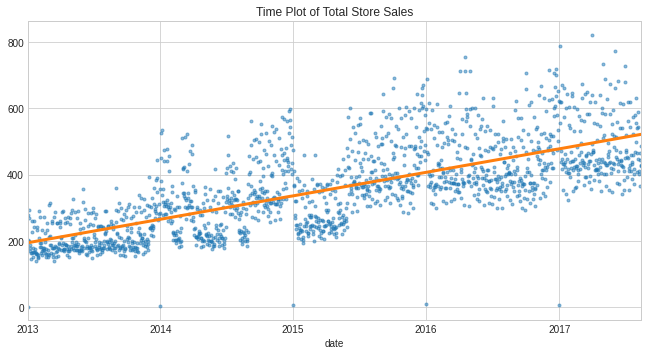

In [24]:
# Prepare training data
X = df.loc[:,['time']]
y = df['sales']

# Train the model
model = LinearRegression()
model.fit(X, y)

# Estimate target
y_hat = pd.Series(model.predict(X), X.index)

# Plot actual and estimated response
fig, ax = plt.subplots(figsize=(11, 5.5))
y.plot(style='.', alpha=0.5)
y_hat.plot(lw=3)
ax.set_title(f'Time Plot of Total Store Sales');

print(f'The linear regression model has an intercept {model.intercept_:.4f} and coefficients {model.coef_.round(4)}.\n')

### Lag Features
To make a **lag feature** we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [25]:
# Create a lag feature from the response variable 'sales'
df = average_sales.copy()
df['lag_1'] = df.sales.shift(1)
df.dropna(inplace=True)
df.head()

,sales,lag_1
date,,
2013-01-02,278.390808,1.409438
2013-01-03,202.840195,278.390808
2013-01-04,198.911148,202.840195
2013-01-05,267.873230,198.911148
2013-01-06,291.636017,267.873230


Simple linear regression with a lag feature produces the model:
$$\text{sales} = \hat{\text{coef}}_{\text{Intercept}} + \hat{\text{coef}}_{\text{lag_1}} \times \text{lag_1}:$$

In [26]:
lm = smf.ols('sales ~ lag_1', data=df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     2400.
Date:                Wed, 27 Oct 2021   Prob (F-statistic):               0.00
Time:                        05:31:28   Log-Likelihood:                -9849.9
No. Observations:                1683   AIC:                         1.970e+04
Df Residuals:                    1681   BIC:                         1.971e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     84.2231      5.954     14.146      0.0

We can expect from the lag plot that a unit sale increase one day will be followed with $\hat{\text{coef}}_{\text{lag_1}} = 0.7653$ unit higher increase the next day in average. The true value of the linear regression line's slope is with $95\%$ confidence in the interval $[0.735, 0.796]$

Lag features let us fit curves to *lag plots* where each observation in a series is plotted against the previous observation:

The linear regression model has an intercept 84.2231 and coefficients [0.7653].



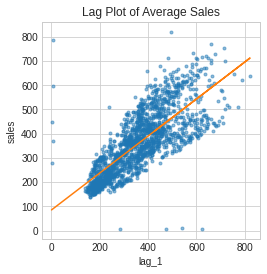

In [27]:
# Prepare training data
X = df.loc[:,['lag_1']]
y = df['sales']

# Train the model
model = LinearRegression()
model.fit(X, y)

# Estimate target
y_hat = pd.Series(model.predict(X), X.index)

# Plot actual and predicted variables
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', alpha=0.5)
ax.plot(X['lag_1'], y_hat)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

print(f'The linear regression model has an intercept {model.intercept_:.4f} and coefficients {model.coef_.round(4)}.\n')

## Analyze Trend
The **trend** component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

### Analyse Trend with Moving Average
To see what kind of trend a time series might have, we can use a **moving average** plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width.

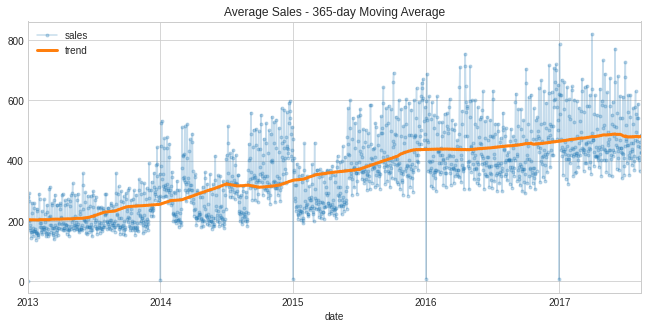

In [28]:
# Compute the moving average
trend = average_sales.rolling(
    window=365,       # 365-day window
    min_periods=183,  # puts the average at the center of the window
    center=True,      # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)
trend.rename(columns={'sales':'trend'}, inplace=True)

# Plot average sales with the moving average
fig, ax = plt.subplots(figsize=(11, 5))
ax = average_sales.plot(ax=ax, style='.-', alpha=0.25)
ax = trend.plot(ax=ax, linewidth=3)
ax.set_title('Average Sales - 365-day Moving Average');

### Analyze Trend with a Time Dummy
Using the `DeterministicProcess` class from `statsmodels` library help us avoid some tricky failure cases that can arise with time series and linear regression.

In [29]:
dp = DeterministicProcess(
    index=average_sales.index,  # dates from the training data
    constant=True,              # dummy feature for regression
    order=3,                    # the time dummies (trend, trend_sqared, trend_cubed)
    drop=True,                  # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
X.tail()

,const,trend,trend_squared,trend_cubed
date,,,,
2017-08-11,1.0,1680.0,2822400.0,4.741632e+09
2017-08-12,1.0,1681.0,2825761.0,4.750104e+09
2017-08-13,1.0,1682.0,2829124.0,4.758587e+09
2017-08-14,1.0,1683.0,2832489.0,4.767079e+09
2017-08-15,1.0,1684.0,2835856.0,4.775582e+09


In [30]:
# `out_of_sample` refers to times outside fo the observation period of the training data
X_fore = dp.out_of_sample(steps=90)
X_fore.head()

,const,trend,trend_squared,trend_cubed
2017-08-16,1.0,1685.0,2839225.0,4.784094e+09
2017-08-17,1.0,1686.0,2842596.0,4.792617e+09
2017-08-18,1.0,1687.0,2845969.0,4.801150e+09
2017-08-19,1.0,1688.0,2849344.0,4.809693e+09
2017-08-20,1.0,1689.0,2852721.0,4.818246e+09


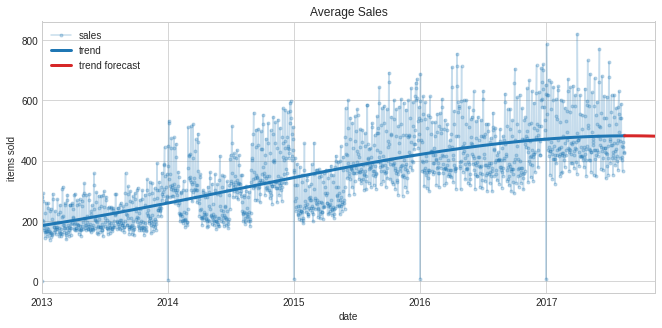

In [36]:
# Train the linear regression model
model = LinearRegression(fit_intercept=False)
y = average_sales['sales'].copy()
model.fit(X, y)

# Regress and predict taget
y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

# Plot the results
fig, ax = plt.subplots(figsize=(11, 5))
ax = y.plot(ax=ax, style='.-', alpha=0.25, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, linewidth=3, label='trend', color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label='trend forecast', color='C3')
ax.legend();

**Note**: The `fit_intercept` Parameter of the [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn.linear_model.LinearRegression) class determinates whether to calculate the intercept for this model. If set to False, no intercept will be used in calculations (i.e. data is expected to be centered). LinearRegression behaves badly with duplicated features, so it is recommended to exclude it. Let's see difference in our example:
```python
model.get_params(), model.intercept_, model.coef_
```
```
({'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False},
 184.84977027834248,
 array([ 0.00000000e+00,  1.74717179e-01,  1.04855132e-04, -6.14730398e-08]))
```
```
({'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'normalize': False},
 0.0,
 array([ 1.84849770e+02,  1.74717179e-01,  1.04855132e-04, -6.14730398e-08]))
```

In [38]:
# Get summary of multiple linear regression model
print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     617.8
Date:                Wed, 27 Oct 2021   Prob (F-statistic):          1.45e-270
Time:                        05:50:10   Log-Likelihood:                -9979.8
No. Observations:                1684   AIC:                         1.997e+04
Df Residuals:                    1680   BIC:                         1.999e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           184.8498      8.869     20.842

**Conclusion**: The $p$-value associated with the $t$-statistic of *trend_squared* is insignificant (i.e. $> 5\%$). The *trend_cubed* is associated with *sales* even though with negligible effect.

### Analyze Trend with Splines
*Splines* are a nice alternative to polynomials when we want to fit a trend. The *Multivariate Adaptive Regression Splines* (MARS) algorithm in the `pyearth` library is a poverful and easy to use.

In [ ]:
# Clone repo
!pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev  --quiet

# Import model
from pyearth import Earth

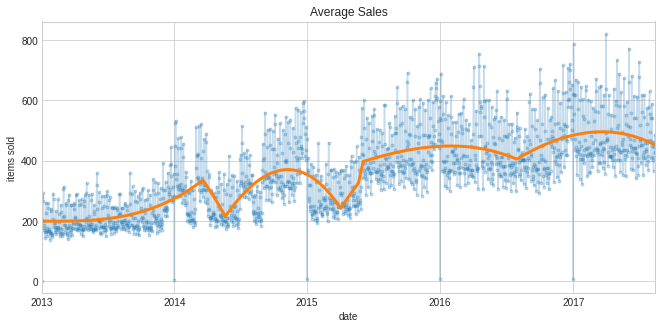

In [40]:
# Using already defined y and X
# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

# Plot the results
fig, ax = plt.subplots(figsize=(11, 5))
ax = y.plot(ax=ax, style='.-', alpha=0.25, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, linewidth=3, label='trend');

Forecasting complicated trends like this will typically be difficult (if not impossible). With historical data, however, you can use splines to isolate other patterns in a time series by *detrending*.


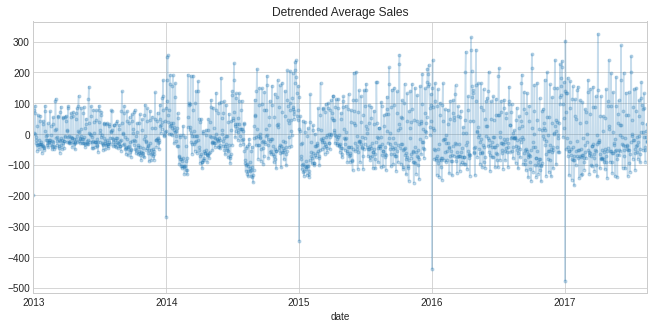

In [41]:
y_detrended = y - y_pred

# Plot the results
fig, ax = plt.subplots(figsize=(11, 5))
ax = y_detrended.plot(ax=ax, style='.-', alpha=0.25, title='Detrended Average Sales');